0=women
1=men
0=no pd
1=pd

In [15]:
## Initial Imports

%matplotlib inline

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold, train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, classification_report, matthews_corrcoef, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from statistics import mean

**`Read data and Display data dimension`**

In [16]:
tqwt_mfccs = pd.read_csv(r'C:\Users\User\Videos\Pd Paper Ref 18 Comparison\binary set\tqwt_mfccs.csv')

tqwt_mfccs.head()


tqwt_entropy_log_dec_10  tqwt_entropy_log_dec_26  tqwt_entropy_log_dec_11  \
0             -281439.2690               -4459.3054             -229943.2967   
1             -285733.2255               -5013.9281             -230526.8175   
2             -305145.0185               -5977.9170             -246592.6024   
3             -287896.7686               -2473.9872             -255107.4287   
4             -279129.6866               -2171.4673             -252647.9964   

   tqwt_energy_dec_18  tqwt_energy_dec_17  tqwt_entropy_log_dec_13  \
0            0.177280            0.089055             -127736.2777   
1            0.242170            0.104610             -136442.1326   
2            0.233100            0.103590             -146506.6418   
3            0.025707            0.041364             -103182.8663   
4            0.020096            0.032471              -97661.8079   

   tqwt_minValue_dec_18  tqwt_entropy_log_dec_30  tqwt_entropy_log_dec_28  \
0              -0.61778               -7011.7391               -3160.3491   
1              -0.50757               -6983.7028               -3212.9726   
2              -0.47225               -6970.5761               -3724.5248   
3              -0.65225               -3853.4907               -4965.0071   
4              -0.62996               -4315.6123               -5832.5871   

   tqwt_entropy_shannon_dec_22  ...  mean_MFCC_4th_coef  mean_MFCC_7th_coef  \
0                     214.7895  ...             0.55527             0.39725   
1                     124.8502  ...             0.45984             0.17695   
2                      34.4880  ...             0.28918             0.70520   
3                     312.2889  ...            -1.55900             0.86495   
4                     284.4293  ...            -1.75500             0.94225   

   mean_MFCC_1st_coef  mean_MFCC_3rd_coef  mean_MFCC_5th_coef  VFER_NSR_TKEO  \
0              8.4781             0.02292             -1.6334         1.2825   
1              8.5008            -0.46733             -1.3427         1.3063   
2              7.6362            -0.48228             -1.7334         1.2614   
3              6.7365             0.75419             -1.0083         1.2369   
4              6.4634             0.83210             -1.0392         1.2360   

   mean_MFCC_10th_coef  VFER_NSR_SEO  std_MFCC_9th_coef  class  
0              0.54775        1.3305            0.28111    1.0  
1              0.54722        1.3177            0.21342    1.0  
2              0.79354        1.3078            0.25827    1.0  
3             -0.89378        1.2986            0.19689    1.0  
4             -1.03360        1.3156            0.17459    1.0  

[5 rows x 25 columns]

In [17]:
df=tqwt_mfccs
train_df=df.values
x_train=train_df[:,:-1]
y_train=train_df[:,-1]

In [18]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train= sc.fit_transform(x_train)
#newly added
kfold=KFold(10, shuffle=True, random_state=10)

In [19]:
def svm_model(X,y, kfold):
    params={'C':[0.1, 1, 10, 100, 1000], 'gamma':[1, 0.1, 0.01, 0.001, 0.0001], 'kernel':['rbf']}

    grid=GridSearchCV(svm.SVC(probability=True, random_state=10),params,cv=kfold, refit=True, verbose=1)
    grid.fit(X,y)
    
    return grid

In [20]:
grid=svm_model(x_train, y_train,kfold)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [21]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [22]:
grid.best_score_

0.9312456140350877

In [23]:
wrong_pred_indices=[]
d={}
svm_estimator=svm.SVC(C= 10, gamma= 0.1, kernel= 'rbf',probability=True, random_state=10)
i=0

correct_ones=[]#collects correct pd postive predictions
correct_zeros=[]#collects correct pd negative predictions

wrong_ones=[]#collect wrong pd positive predictions
wrong_zeros=[]#collect wrong pd negative predictions

tp=[]# true positive
tn=[]# true negative
fp=[]# false positive
fn=[]# false negative

tridx=[]
tstidx=[]
acc=[]
mcc=[]
f1=[]

for trids, tstids in kfold.split(x_train):
    
    trainx, testx= x_train[trids,:], x_train[tstids,:]
    trainy, testy= y_train[trids], y_train[tstids]
    
    svm_estimator.fit(trainx, trainy)
    
    preds=svm_estimator.predict(x_train[tstids,:])
    
    acc.append(accuracy_score(testy,svm_estimator.predict(testx)))
    mcc.append(matthews_corrcoef(testy, svm_estimator.predict(testx)))
    f1.append(f1_score(testy, svm_estimator.predict(testx)))
    
    #print(classification_report(testy, svm_estimator.predict(testx)))
    #print('matthews_corrcoef:')
    #print(matthews_corrcoef(testy, svm_estimator.predict(testx)))
    #print('roc_auc:')
    #print(roc_auc_score(testy, svm_estimator.predict(testx)))
    
    #print('#######')
    #d['fold'+str(i)]=classification_report(testy, svm_estimator.predict(testx))
    
    if (i==9):#checking if it is last split
        tridx=trids
        tstidx=tstids

        for j in range(len(tstids)):
            if(preds[j]==0 and (y_train[tstids[j]]==0) ):
                correct_zeros.append(j)
                tn.append(j)
                
            if(preds[j]==0 and (y_train[tstids[j]]==1) ):
                wrong_zeros.append(j)
                fn.append(j)
                
            if(preds[j]==1 and (y_train[tstids[j]]==1) ):
                correct_ones.append(j)
                tp.append(j)
                
            if(preds[j]==1 and y_train[tstids[j]]==0):
                wrong_ones.append(j)  
                fp.append(j)
    i=i+1

print('acc:', mean(acc))
print('f1:', mean(f1))
print('mcc:', mean(mcc))


acc: 0.9312456140350878
f1: 0.9546847234897868
mcc: 0.8086499230958185


In [24]:
print(len(correct_ones)) # true positive
print(len(correct_zeros))
print(len(wrong_ones))
print(len(wrong_zeros))
print(len(correct_ones)+len(wrong_ones)+len(correct_zeros)+len(wrong_zeros))
print(len(tstidx))

46
22
5
2
75
75


In [25]:
print("true positive: ", len(tp))
print("true negative: ", len(tn))
print("false positive: ", len(fp))
print("false negative: ", len(fn))

true positive:  46
true negative:  22
false positive:  5
false negative:  2


### The rest are useless here

In [26]:
print("true positive: ", tp)
print("true negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)

true positive:  [0, 1, 2, 3, 6, 7, 10, 12, 13, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33, 36, 41, 42, 43, 44, 48, 49, 51, 52, 53, 54, 55, 56, 58, 59, 60, 63, 64, 65, 70, 74]
true negative:  [5, 8, 9, 11, 14, 16, 34, 35, 37, 39, 40, 45, 46, 47, 62, 66, 67, 68, 69, 71, 72, 73]
false positive:  [15, 25, 38, 57, 61]
false negative:  [4, 50]


In [27]:
len(correct_zeros)
print(correct_zeros[:2])

[5, 8]


In [28]:
import shap
shap.initjs()

In [29]:
svm_estimator

SVC(C=10, gamma=0.1, probability=True, random_state=10)

In [30]:
model=svm_estimator.fit(x_train[tridx,:], y_train[tridx])
print(classification_report(y_train[tstidx], model.predict(x_train[tstidx,:])))

              precision    recall  f1-score   support

         0.0       0.92      0.81      0.86        27
         1.0       0.90      0.96      0.93        48

    accuracy                           0.91        75
   macro avg       0.91      0.89      0.90        75
weighted avg       0.91      0.91      0.91        75



In [31]:
type(tstidx[2])

numpy.int32

In [32]:
trainx=x_train[tridx,:]
trainy=y_train[tridx]
testx=x_train[tstidx,:]
testy=y_train[tstidx]

svm_=svm.SVC(C=10, gamma=0.01, probability=True, random_state=10)
svm_.fit(trainx,trainy)

#testx_summary = shap.kmeans(testx, 10)
explainer = shap.KernelExplainer(svm_.decision_function, testx, link='identity')
shap_values = explainer.shap_values(testx)

  0%|          | 0/75 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [33]:
svm_estimator

SVC(C=10, gamma=0.1, probability=True, random_state=10)

In [34]:
svm_.decision_function

<bound method BaseSVC.decision_function of SVC(C=10, gamma=0.01, probability=True, random_state=10)>

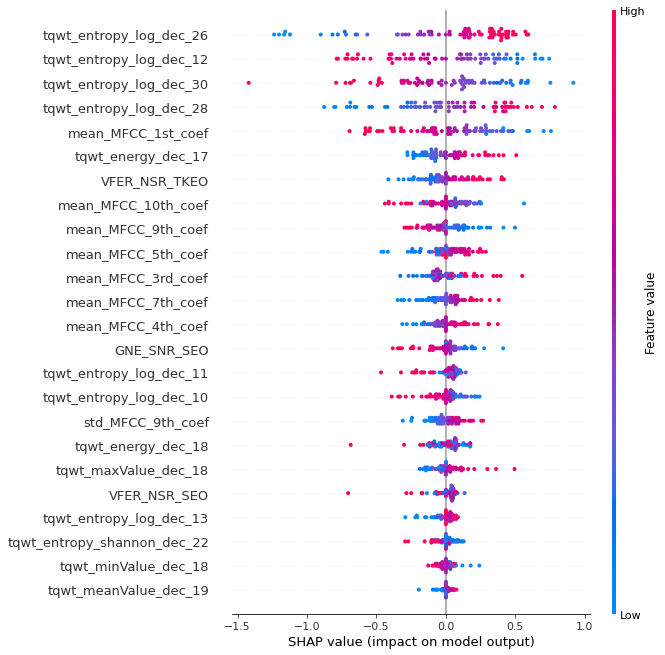

In [35]:
shap.summary_plot(shap_values, testx,feature_names=list(df.columns), max_display=71, show=False)
plt.savefig('svm_gender_top_all.png', dpi=300, bbox_inches='tight')


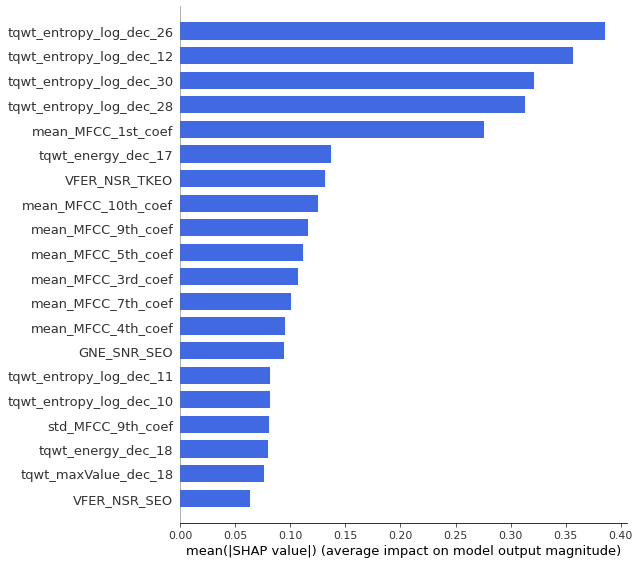

In [36]:
shap.summary_plot(shap_values, testx,feature_names=list(df.columns), max_display=20, plot_type='bar', color='royalblue', show=False)
plt.savefig('svm_gender_bar_20_features.png', dpi=300, bbox_inches='tight')

In [37]:
import warnings
warnings.filterwarnings('ignore')

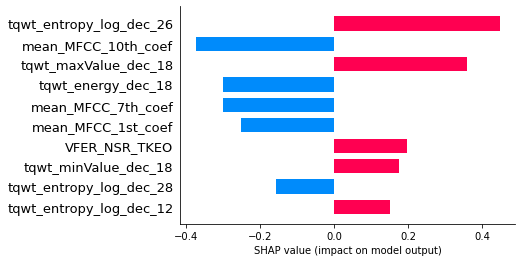

In [38]:
shap.bar_plot(explainer.shap_values(testx[3]),feature_names=list(df.columns), max_display=10,show=False)
plt.savefig('data3_true_positive_prediction.png', dpi=300, bbox_inches='tight')

In [39]:
svm_.predict(testx[[1,3,10,20,21],:])

array([1., 1., 1., 1., 1.])

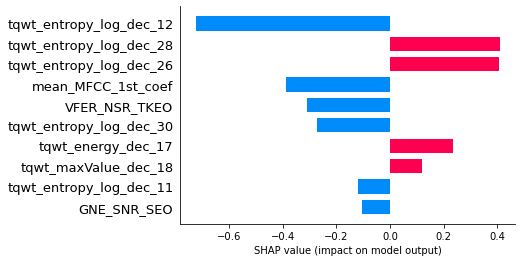

In [40]:
shap.bar_plot(explainer.shap_values(testx[8]),feature_names=list(df.columns),max_display=10, show=False)
plt.savefig('data_5_true_negative.png', dpi=300, bbox_inches='tight')

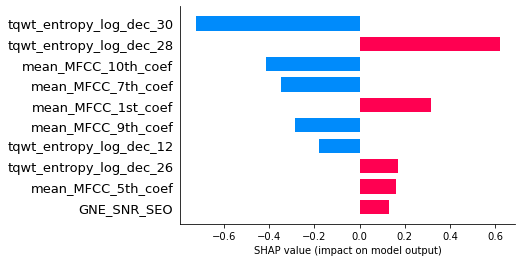

In [41]:
shap.bar_plot(explainer.shap_values(testx[25]),feature_names=list(df.columns),max_display=10, show=False)
plt.savefig('data_25_false_positive.png', dpi=300, bbox_inches='tight')

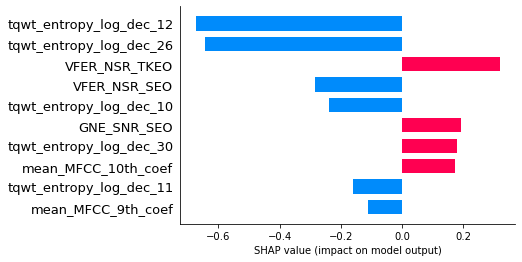

<Figure size 432x288 with 0 Axes>

In [42]:
shap.bar_plot(explainer.shap_values(testx[50]),feature_names=list(df.columns),max_display=10, show=True)
plt.savefig('data_50_false_negative_negative.png', dpi=300, bbox_inches='tight')

In [43]:
from matplotlib import pyplot as plt
import matplotlib
matplotlib.pyplot.ion()
%matplotlib inline

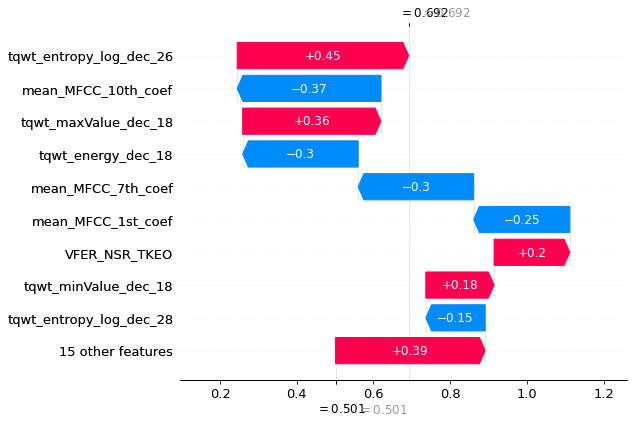

<Figure size 432x288 with 0 Axes>

In [44]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[3], feature_names=list(df.columns), show=True)
plt.savefig('data_3_correct_prediction_waterfall.png', dpi=300, bbox_inches='tight')

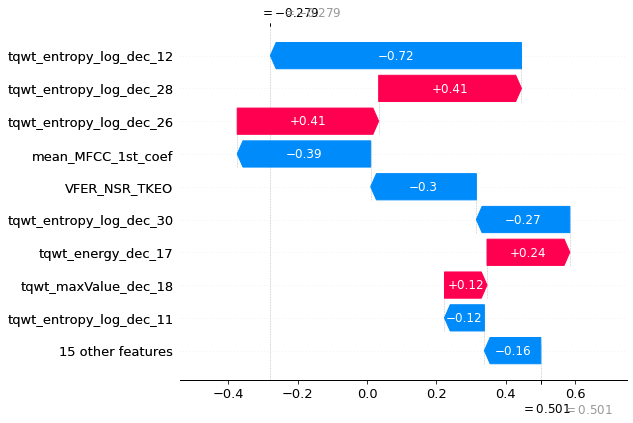

<Figure size 432x288 with 0 Axes>

In [45]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[8], feature_names=list(df.columns), show=True)
plt.savefig('data_8_correct_prediction_waterfall.png', dpi=300, bbox_inches='tight')

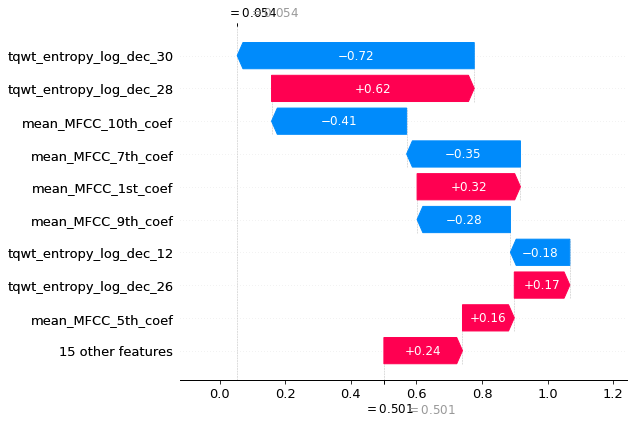

<Figure size 432x288 with 0 Axes>

In [46]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[25], feature_names=list(df.columns), show=True)
plt.savefig('data_25_false_positive_waterfall.png', dpi=300, bbox_inches='tight')

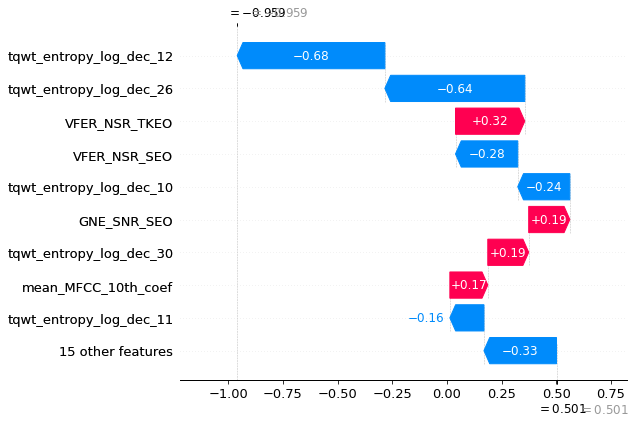

<Figure size 432x288 with 0 Axes>

In [47]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[50], feature_names=list(df.columns), show=True)
plt.savefig('data_50_false_positive_waterfall.png', dpi=300, bbox_inches='tight')

Lime explanations

In [48]:
import lime
import lime.lime_tabular
#import eli5

In [49]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(testx, feature_names=list(df.columns),
                                                  class_names=[0,1], verbose=True, mode='classification')

wrong indices of  testx:[5, 8, 50, 57, 70]

In [50]:
lime_explainer.random_state.seed(10)

In [51]:
svm_.predict(testx[[1,3,10,5,57,70],:])

array([1., 1., 1., 1., 1., 0.])

In [52]:
#correct prediction
print('instance 3 ( prediction):')
e3=lime_explainer.explain_instance(testx[3],svm_.predict_proba, num_features=10)
print('instance 8 ( prediction):')
e8=lime_explainer.explain_instance(testx[8],svm_.predict_proba, num_features=10)
print('instance 25 (prediction):')
e25=lime_explainer.explain_instance(testx[25],svm_.predict_proba, num_features=10)
print('instance 50 ( prediction):')
e50=lime_explainer.explain_instance(testx[50],svm_.predict_proba, num_features=10)
#wrong prediction
#print('instance 5 ( prediction):')
#e5=lime_explainer.explain_instance(testx[5],svm_.predict_proba, num_features=10)
#print('instance 57 ( prediction):')
#e57=lime_explainer.explain_instance(testx[57],svm_.predict_proba, num_features=10)
#print('instance 70 (prediction):')
#e70=lime_explainer.explain_instance(testx[70],svm_.predict_proba, num_features=10)

instance 3 ( prediction):
Intercept 0.6627567598397771
Prediction_local [0.68030586]
Right: 0.7792002853499137
instance 8 ( prediction):
Intercept 0.8193505473108158
Prediction_local [0.21553175]
Right: 0.3835969017142264
instance 25 (prediction):
Intercept 0.658182620018762
Prediction_local [0.67992877]
Right: 0.529472575364759
instance 50 ( prediction):
Intercept 0.7387459026651721
Prediction_local [0.42687777]
Right: 0.15478555213700296


In [53]:
e3.show_in_notebook(show_table=True)
plt.savefig('data_3_true_positive_lime.png', dpi=300, bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

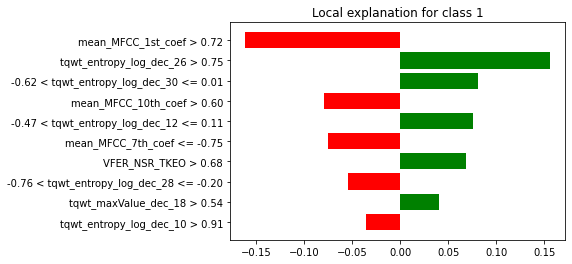

In [54]:
explanation=e3.as_pyplot_figure()
explanation.savefig('e3_true_positive_explanation.png',dpi=300, bbox_inches='tight')

In [55]:
e8.show_in_notebook(show_table=True)
plt.savefig('data_8_true_negative_lime.png', dpi=300, bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

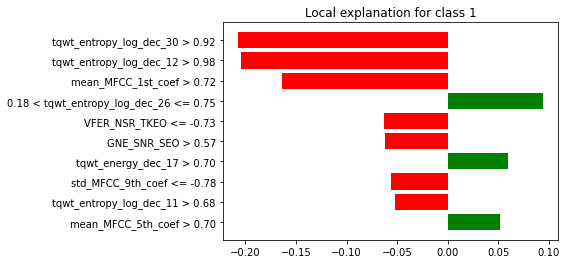

In [56]:
explanation=e8.as_pyplot_figure()
explanation.savefig('e8_true_negative_explanation.png',dpi=300, bbox_inches='tight')

In [59]:
e25.show_in_notebook(show_table=True)
plt.savefig('data_25_false_positive_lime.png', dpi=300, bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

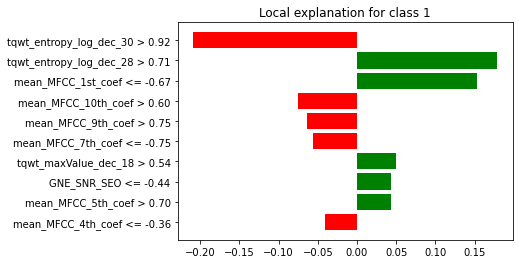

In [60]:
explanation=e25.as_pyplot_figure()
explanation.savefig('e25_false_positive_explanation.png',dpi=300, bbox_inches='tight')

In [61]:
e50.show_in_notebook(show_table=True)
plt.savefig('data_50_false_negative_lime.png', dpi=300, bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

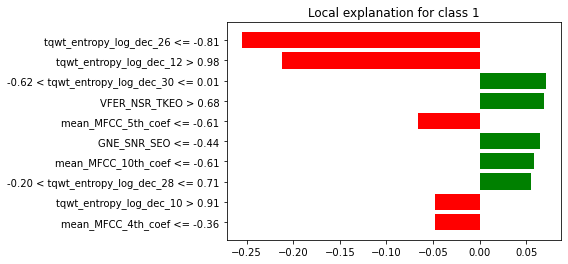

In [62]:
explanation=e50.as_pyplot_figure()
explanation.savefig('e5_false_negative_explanation.png',dpi=300, bbox_inches='tight')

In [63]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(lime_explainer,label=0, testx, svm_.predict_proba, sample_size=20, num_features=30, num_exps_desired=5)

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_1144/824655302.py, line 2)

In [88]:
plt.style.context('default')




KeyError: 1

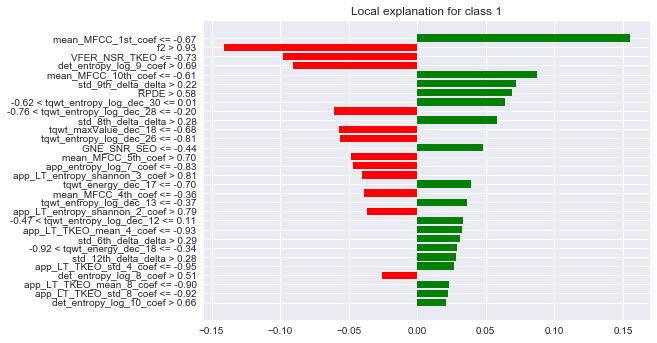

In [89]:
[exp.as_pyplot_figure() for exp in sp_obj.sp_explanations];

KeyError: 0

In [81]:
from lime import submodular_pick
sp_obj = submodular_pick.SubmodularPick(lime_explainer, testx, svm_.predict, sample_size=20, num_features=14, num_exps_desired=5)

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16